1. [Check missing data or NaN](#section1)   
2. [Data exploration](#section2)   

Analysis on 
1. [Age](#age)
2. [Pages visited](#pages)
3. [New user](#new_user)

Columns:    
country : user country based on the IP address    
age : user age. Self-reported at sign-in step    
new_user : whether the user created the account during this session or had already an account and simply came back to the site    
source : marketing channel source    
Ads: came to the site by clicking on an advertisement    
Seo: came to the site by clicking on search results    
Direct: came to the site by directly typing the URL on the browser    
total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.    
converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions.    

In [1]:
import pandas as pd
import numpy as np

columns=['country','age','new_user','source','total_pages_visited','converted']
df = pd.read_csv('conversion_data.csv')
df.columns=columns
df.head(2)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0


<a id = 'section1'></a>
## Check for missing data, or NaN

In [2]:
# 1. Throw out duplicated data:
#print(len(df))
#df = df[df.duplicated() == False]
#print(len(df))
# Probably don't drop duplicated for this kind of data

# 2. Check for NaNs:
print(df.isnull().values.any())
#No null values

False


<a id='section2'></a>
## Data exploration

In [3]:
df['converted'] = df['converted'].astype('category')
df['new_user'] = df['new_user'].astype('category')
df.describe()

,age,total_pages_visited
count,316200.000000,316200.000000
mean,30.569858,4.872966
std,8.271802,3.341104
min,17.000000,1.000000
25%,24.000000,2.000000
50%,30.000000,4.000000
75%,36.000000,7.000000
max,123.000000,29.000000


People can span an age of up to 123 years!!,    
let's put a top limit of 100 years

In [4]:
print(df[df['age']>100])
df = df.drop(df[df['age']>100].index)

        country  age new_user source  total_pages_visited converted
90928   Germany  123        0    Seo                   15         1
295581       UK  111        0    Ads                   10         1


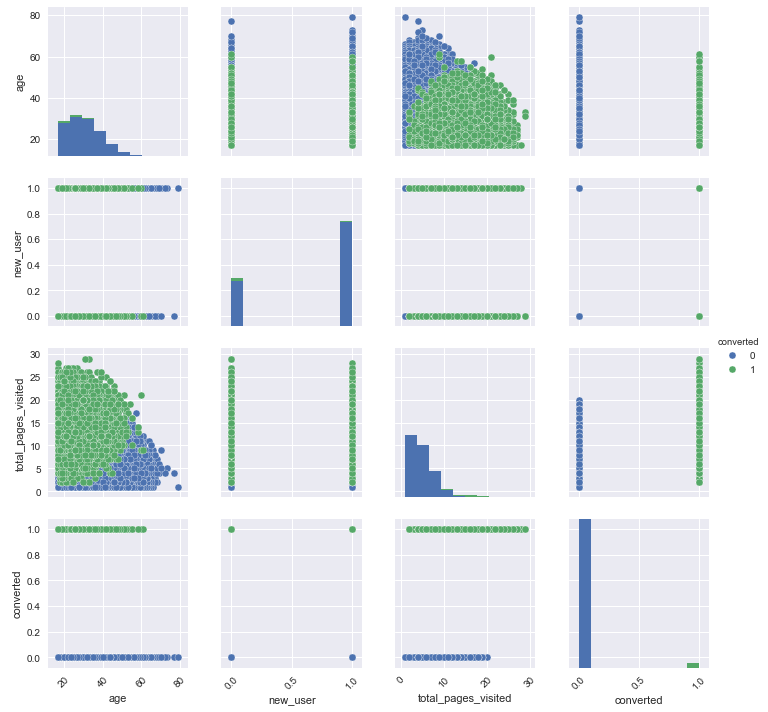

In [5]:
% matplotlib inline
import seaborn as sns
import matplotlib as plt

g = sns.pairplot(df[["age", "new_user", "total_pages_visited", "converted"]], hue="converted", diag_kind="hist")
 
for ax in g.axes.flat: 
    plt.artist.setp(ax.get_xticklabels(), rotation=45)

Many of the features seem to be correlated with conversion, let's analyze each one in detail.

<a id='age'></a>
### Age

In [37]:
age_categories={1:'17 to 24',2:'24 to 29',3:'30 to 35',4:'36 to 100'}

def get_age_category(x):
    """Gets an age category"""
    global age_categories
    
    if (x < 24):
        category = 1
    elif (x < 29):
        category = 2
    elif (x < 35):
        category = 3
    else:
        category = 4
    return age_categories[category]

df['age_category'] = df['age'].apply(get_age_category)
df['age_category'] = df['age_category'].astype('category')

In [7]:
df.describe()

,age,total_pages_visited
count,316198.000000,316198.000000
mean,30.569311,4.872918
std,8.268958,3.341053
min,17.000000,1.000000
25%,24.000000,2.000000
50%,30.000000,4.000000
75%,36.000000,7.000000
max,79.000000,29.000000


In [8]:
#df_age = df.groupby('age_category').agg({'converted':'count'})

#df_age
df_age = df.groupby('age_category').agg({'converted':'value_counts'}).rename(
    columns={'converted':'converted_counts'})

#df_age = df_age.sort_values('converted_counts',ascending=True)

df_age


converted_counts
age_category converted                  
17 to 24     0                     66533
             1                      4038
24 to 29     0                     66172
             1                      2604
30 to 35     0                     78275
             1                      2167
36 to 100    0                     95020
             1                      1389

In [9]:
df_age.index
df_age_converted = df_age.query('(converted==1)').sort_values('converted_counts',ascending=True)
df_age_converted.index = df_age_converted.index.droplevel(1)

df_age_converted

,converted_counts
age_category,
36 to 100,1389
30 to 35,2167
24 to 29,2604
17 to 24,4038


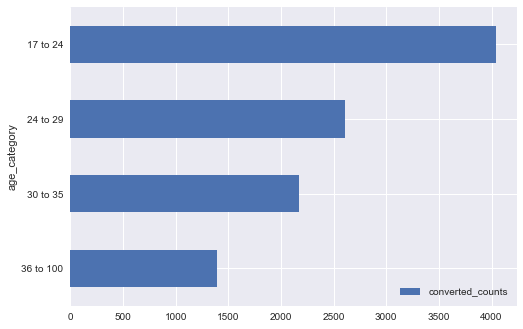

In [10]:
plt.pyplot.figure(figsize=(15, 4))

df_age_converted.plot(kind='barh')


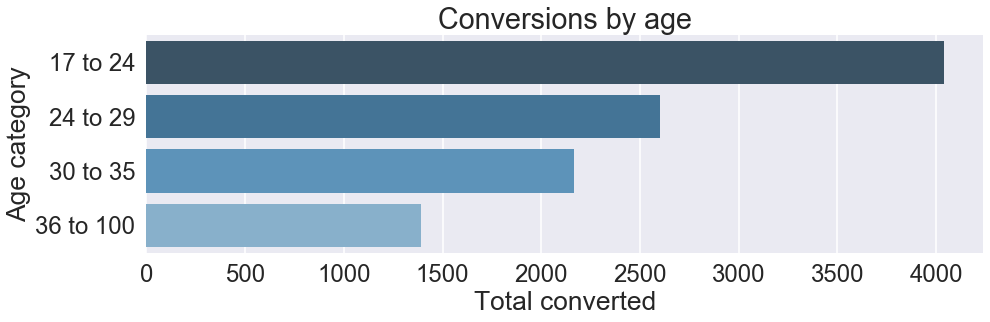

In [11]:
# Initialize the matplotlib figure
#f, ax = plt.pyplot.subplots(figsize=(15, 6))

#Set context, increase font size
sns.set_context("poster", font_scale=1.5)
#Create a figure
plt.pyplot.figure(figsize=(15, 4))
#Define the axis object
ax = sns.barplot(x='converted_counts', y=df_age_converted.index, data=df_age_converted, palette="Blues_d")
#set paramters
ax.set(xlabel='Total converted', ylabel='Age category', title= "Conversions by age")
#show the plot
sns.plt.show()

<a id = 'pages_visited'></a>
## Pages visited

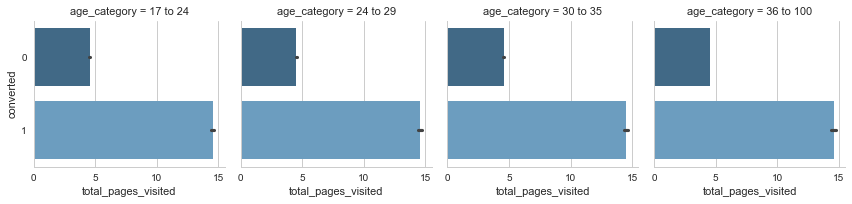

In [12]:
sns.set(style="whitegrid")
#sns.barplot( x="converted", y="age_category", data=df,
#            label="Total", color="b")

g = sns.FacetGrid(df, col="age_category") 
g.map(sns.barplot, "total_pages_visited","converted",palette="Blues_d") 


Total pages visited is correlated with conversion independent of age.

<a id='new_user'></a>

## New user

In [66]:
df_new_user = df.query( '( new_user==1) ')
df_other = df.query( '( new_user==0) ')


df_new_user = df_new_user.groupby('age_category').agg({'converted':'value_counts'})
df_other = df_other.groupby('age_category').agg({'converted':'value_counts'})
print(df_new_user)
print(df_other)

                        converted
age_category converted           
17 to 24     0              46605
             1               1221
24 to 29     0              46277
             1                744
30 to 35     0              54565
             1                647
36 to 100    0              66258
             1                427
                        converted
age_category converted           
17 to 24     0              19928
             1               2817
24 to 29     0              19895
             1               1860
30 to 35     0              23710
             1               1520
36 to 100    0              28762
             1                962


In [72]:
# Get ratio of converted people by age category:
def get_ratio(df_input,age_category):
    non_converted = df_input.loc[age_category,0].values[0]
    converted = df_input.loc[age_category,1].values[0]
    ratio = converted/(non_converted + converted)
    return ratio

converted_ratio = []
for age_category in age_categories.values():
    ratio_new_user = get_ratio(df_new_user,age_category)
    ratio_other = get_ratio(df_other,age_category)
    converted_ratio.append([age_category,'new user',ratio_new_user])
    converted_ratio.append([age_category,'other user',ratio_other])

    
df_ratio = pd.DataFrame(data=converted_ratio,columns=['age category','user kind','ratio'])
df_ratio['age category'] = df_ratio['age category'].astype('category')
df_ratio['user kind'] = df_ratio['user kind'].astype('category')

df_ratio.head()

,age category,user kind,ratio
0,17 to 24,new user,0.025530
1,17 to 24,other user,0.123851
2,24 to 29,new user,0.015823
3,24 to 29,other user,0.085498
4,30 to 35,new user,0.011718


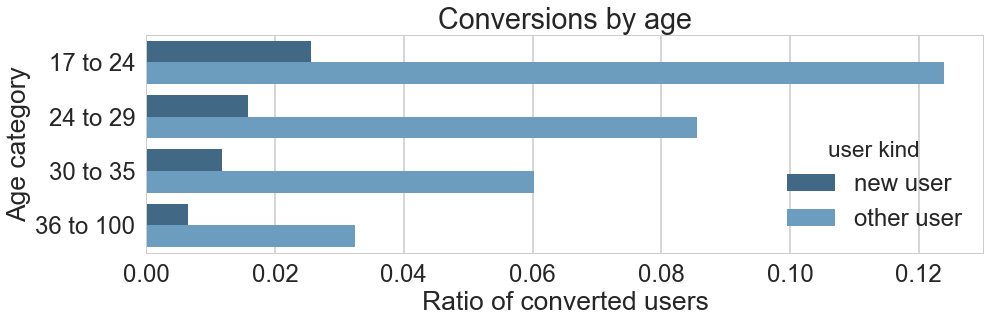

In [73]:
# Initialize the matplotlib figure
#f, ax = plt.pyplot.subplots(figsize=(15, 6))

#Set context, increase font size
sns.set_context("poster", font_scale=1.5)
#Create a figure
plt.pyplot.figure(figsize=(15, 4))
#Define the axis object
ax = sns.barplot(x=df_ratio.ratio, y=df_ratio['age category'], hue='user kind', data=df_ratio, palette="Blues_d")
#set paramters
ax.set(xlabel='Ratio of converted users', ylabel='Age category', title= "Conversions by age")
#show the plot
sns.plt.show()